# Anomaly Detection on MNIST

This notebook shows how a Deep Learning Auto-Encoder model can be used to find outliers in a dataset. 

Consider the following three-layer neural network with one hidden layer and the same number of input neurons (features) as output neurons.  The loss function is the MSE between the input and the output.  Hence, the network is forced to learn the identity via a nonlinear, reduced representation of the original data.  Such an algorithm is called a deep autoencoder; these models have been used extensively for unsupervised, layer-wise pretraining of supervised deep learning tasks, but here we consider the autoencoder's application for discovering anomalies in data.

We use the well-known MNIST dataset of hand-written digits, where each row contains the 28^2=784 raw gray-scale pixel values from 0 to 255 of the digitized digits (0 to 9).

## Load Keras, TensorFlow, and the MNIST training/testing datasets

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,8) # Make the figures a bit bigger

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
# Seed for reproducibility
np.random.seed(42)

## Load training data

In [3]:
batch_size = 64
nb_epoch = 5

In [4]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


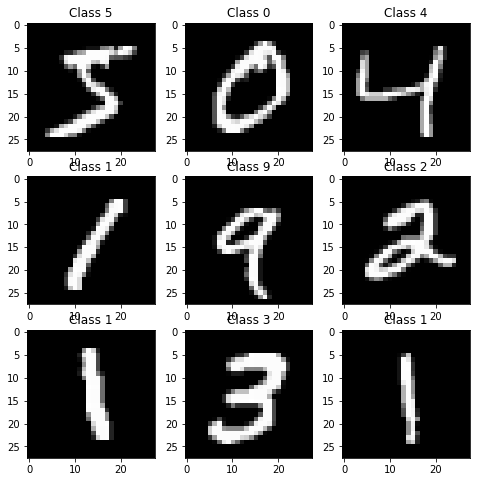

In [5]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

## Format the data for training
ur neural-network is going to take a single vector for each training example, so we need to reshape the input so that each 28x28 image becomes a single 784 dimensional vector. We'll also scale the inputs to be in the range [0-1] rather than [0-255]

In [6]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


## Finding outliers - ugly hand-written digits

We train a Deep Learning Auto-Encoder to learn a compressed (low-dimensional) non-linear representation of the dataset, hence learning the intrinsic structure of the training dataset. The auto-encoder model is then used to transform all test set images to their reconstructed images, by passing through the lower-dimensional neural network. We then find outliers in a test dataset by comparing the reconstruction of each scanned digit with its original pixel values. The idea is that a high reconstruction error of a digit indicates that the test set point doesn't conform to the structure of the training data and can hence be called an outlier.

### Learn what's normal from the training data

Train unsupervised Deep Learning autoencoder model on the training dataset. For simplicity, we train a model with 1 hidden layer of 50 Tanh neurons to create 50 non-linear features with which to reconstruct the original dataset.  For now, please accept that 50 hidden units is a reasonable choice... 

For simplicity, we train the auto-encoder for only 5 epoch (fives passes over the entire traing dataset).  

In [8]:
# A very simple network, an autoencoder with a single hidden layer of 50 neurons
model = Sequential()
model.add(Dense(784, input_dim=784, kernel_initializer='normal'))

model.add(Dense(50, kernel_initializer='normal'))
model.add(Activation('tanh'))

model.add(Dense(784, kernel_initializer='normal'))
model.add(Activation('sigmoid'))

In [9]:
# prints a summary representation of the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                39250     
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               39984     
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
Total params: 694,674
Trainable params: 694,674
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

## Train the model

In [11]:
history = model.fit(X_train, X_train,
                    batch_size=batch_size, epochs=nb_epoch,
                    verbose=2)

Epoch 1/5
11s - loss: 0.0710 - acc: 0.0113
Epoch 2/5
11s - loss: 0.0674 - acc: 0.0126
Epoch 3/5
11s - loss: 0.0674 - acc: 0.0122
Epoch 4/5
10s - loss: 0.0672 - acc: 0.0112
Epoch 5/5
11s - loss: 0.0416 - acc: 0.0115


### Find outliers in the test data

The Anomaly app computes the per-row reconstruction error for the test data set. It passes it through the autoencoder model (built on the training data) and computes mean square error (MSE) for each row in the test set.

In [12]:
test_reconstructed = model.predict(X_test)
test_loss = mean_squared_error(X_test, test_reconstructed, multioutput='raw_values')

## Visualize the good, the bad and the *ugly*

We will need a helper function for plotting handwritten digits:

In [13]:
def plot_by_index(X, indices):
    plt.figure(figsize=(12,3))
    for i in range(len(indices)):
        plt.subplot(1, 12, i+1)
        plt.imshow(X[indices[i]].reshape((28, 28)), cmap='gray', interpolation='nearest')
        plt.axis('off')

Let's look at the test set points with low/median/high reconstruction errors. We will now visualize the original test set points and their reconstructions obtained by propagating them through the narrow neural net.

In [14]:
# Sort the test set into recostruction error order
test_loss_sorted_indices = np.argsort( test_loss )

In [15]:
# Here are the best ones
test_loss[ test_loss_sorted_indices[0:10] ]

array([  3.80918427e-05,   4.33224486e-05,   4.43861463e-05,
         4.76358364e-05,   5.16450054e-05,   5.25317264e-05,
         5.40664005e-05,   5.50754594e-05,   5.51085468e-05,
         5.51765552e-05], dtype=float32)

### The good

Let's plot the 12 digits with lowest reconstruction error. First we plot the reconstruction, then the original scanned images.

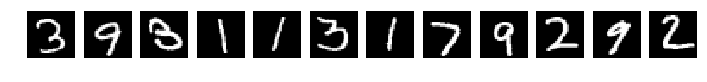

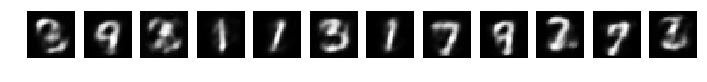

In [16]:
indices = test_loss_sorted_indices[0:12]

plot_by_index(X_test, indices)
plot_by_index(test_reconstructed, indices)

Clearly, a well-written digit 1 appears in both the training and testing set, and is easy to reconstruct by the autoencoder with minimal reconstruction error. Nothing is as easy as a straight line.

### The bad

Now let's look at the 12 digits with median reconstruction error.

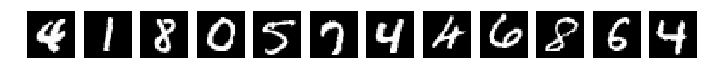

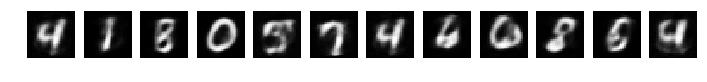

In [17]:
mid = len(test_loss_sorted_indices)//2
indices = test_loss_sorted_indices[mid-6:mid+6]

plot_by_index(X_test, indices)
plot_by_index(test_reconstructed, indices)

These test set digits look "normal" - it is plausible that they resemble digits from the training data to a large extent, but they do have some particularities that cause some reconstruction error.

### The ugly

And here are the biggest outliers - The 12 digits with highest reconstruction error!

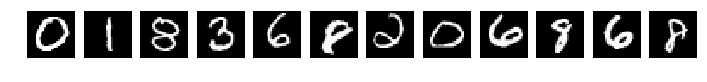

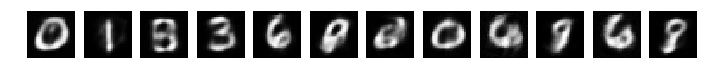

In [18]:
indices = test_loss_sorted_indices[-12:]

plot_by_index(X_test, indices)
plot_by_index(test_reconstructed, indices)

Now here are some pretty ugly digits that are plausibly not commonly found in the training data - some are even hard to classify by humans.

## Voila!

We were able to find outliers with Deep Learning Auto-Encoder models